In [2]:
# --------- Imports ---------

# General Imports
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import seaborn as sns


# Opening Images Imports
import czifile
from pathlib import Path
from lxml import etree


# Visualizing Images Imports
import napari
from napari.utils import nbscreenshot


# Filtering Images Imports
import skimage
import skimage.draw
from skimage import morphology
from skimage import img_as_float
from skimage import exposure
from skimage import filters
from skimage.morphology import reconstruction, disk, white_tophat, square, opening
from skimage.restoration import rolling_ball, denoise_bilateral
from skimage.filters import threshold_otsu
from skimage.measure import regionprops, regionprops_table

from scipy.ndimage import gaussian_filter
from pyclesperanto_prototype import imshow


# Image Segmentation Imports
from stardist.models import StarDist2D
from skimage.segmentation import find_boundaries

# Teselation Imports
from scipy.spatial import Voronoi, voronoi_plot_2d, distance

# Clustering Imports
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture




2023-11-09 10:57:11.730159: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-09 10:57:11.730200: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-09 10:57:11.731775: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-09 10:57:11.901987: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Read the previously saved DataFrame

# Define the directory path
directory_3 = "./results/slice_3/"
csv_file_path_3 = os.path.join(directory_3, "cell_features_slice_3.csv")


# Define the directory path
directory_4 = "./results/slice_4/"
csv_file_path_4 = os.path.join(directory_4, "cell_features_slice_4.csv")

# # Read the CSV file into a DataFrame
df_slice_3 = pd.read_csv(csv_file_path_3)
df_slice_4 = pd.read_csv(csv_file_path_4)

In [3]:
df_slice_3

,label,area,centroid-0,centroid-1,equivalent_diameter,bbox_area,convex_area,filled_area,major_axis_length,minor_axis_length,...,extent,feret_diameter_max,max_intensity,mean_intensity,min_intensity,orientation,perimeter,solidity,Fluorescence_Intensity,filtered_GMM_stemness
0,1,3204.0,1662.641074,607.815855,63.870647,4347.0,3259.0,3204.0,68.786238,59.820723,...,0.737060,71.470274,0.325997,0.264932,0.016023,-0.344251,211.965512,0.983124,31.786206,0.0
1,2,5083.0,1189.104072,636.635058,80.447975,7020.0,5173.0,5083.0,95.232220,68.448353,...,0.724074,97.948966,0.504318,0.378100,0.085399,0.544918,274.592929,0.982602,63.255543,1.0
2,3,3300.0,1452.323939,1065.436364,64.820448,4453.0,3371.0,3300.0,70.715113,59.675364,...,0.741073,75.186435,0.589241,0.460765,0.189586,0.186678,217.137085,0.978938,41.725963,0.0
3,4,5203.0,1471.086296,1512.976936,81.392047,7216.0,5275.0,5203.0,91.614034,72.756361,...,0.721037,93.407708,0.630762,0.494673,0.143238,-0.972377,271.563492,0.986351,77.387800,1.0
4,5,4578.0,1466.881171,652.288554,76.347172,6231.0,4672.0,4578.0,91.330323,64.443021,...,0.734714,93.770998,0.349929,0.270635,0.067041,0.080902,261.521861,0.979880,51.567918,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,185,805.0,976.858385,1397.991304,32.014963,1258.0,870.0,805.0,40.926492,26.079088,...,0.639905,42.201896,0.570675,0.373405,0.072562,0.609956,114.811183,0.925287,28.262028,0.0
185,186,936.0,667.054487,1055.739316,34.521764,1215.0,969.0,936.0,46.539594,25.716896,...,0.770370,45.891176,0.353829,0.178807,0.097310,1.407554,120.083261,0.965944,7.395071,0.0
186,187,932.0,598.084764,1377.718884,34.447921,2016.0,1122.0,932.0,49.617094,28.355663,...,0.462302,57.271284,0.455039,0.310005,0.103684,0.253947,148.539105,0.830660,16.027611,0.0
187,188,5171.0,1854.631986,1020.615935,81.141369,7303.0,5683.0,5171.0,111.049149,60.884924,...,0.708065,109.553640,0.227770,0.135792,0.051253,1.541272,303.663997,0.909907,0.000000,0.0


In [4]:
df_slice_4

,label,area,centroid-0,centroid-1,equivalent_diameter,bbox_area,convex_area,filled_area,major_axis_length,minor_axis_length,...,extent,feret_diameter_max,max_intensity,mean_intensity,min_intensity,orientation,perimeter,solidity,Fluorescence_Intensity,filtered_GMM_stemness
0,1,2928.0,336.119536,1003.001366,61.057722,3888.0,3117.0,2928.0,75.252589,52.102354,...,0.753086,77.252832,0.650847,0.366038,0.093204,1.367168,218.066017,0.939365,72.148516,0.0
1,2,4097.0,1143.781792,725.897242,72.225082,5320.0,4160.0,4097.0,76.770961,68.162206,...,0.770113,77.665951,0.542441,0.322416,0.082954,-1.286684,238.793939,0.984856,50.447730,0.0
2,3,4783.0,1303.789672,1549.289985,78.037842,6960.0,4874.0,4783.0,100.779594,61.433336,...,0.687213,105.261579,0.755263,0.549903,0.193432,-0.748998,274.936075,0.981330,62.843534,0.0
3,4,5471.0,650.496801,610.031804,83.461929,7584.0,5552.0,5471.0,98.198499,71.280951,...,0.721387,99.368003,0.550419,0.357820,0.147641,1.152111,281.563492,0.985411,154.907576,1.0
4,5,4215.0,343.074259,1239.216845,73.257796,6448.0,4398.0,4215.0,100.105184,54.770636,...,0.653691,104.479663,0.770128,0.574122,0.161743,1.427078,269.421356,0.958390,17.530114,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,297,2519.0,1072.697896,1415.281064,56.632945,4779.0,2955.0,2519.0,79.073962,45.829585,...,0.527098,83.198558,0.518417,0.323519,0.138507,-0.992561,227.965512,0.852453,59.356619,0.0
297,298,6197.0,1978.480878,1259.691302,88.827166,8134.0,6281.0,6197.0,98.254018,80.705840,...,0.761864,100.687636,0.190788,0.102544,0.031052,1.569849,297.078210,0.986626,245.516274,1.0
298,299,116.0,898.706897,2046.241379,12.153016,156.0,124.0,116.0,13.623074,11.003209,...,0.743590,14.317821,0.331281,0.211591,0.077986,-0.484516,38.970563,0.935484,35.536980,0.0
299,300,1010.0,1099.429703,1021.994059,35.860451,1496.0,1070.0,1010.0,44.019700,29.895665,...,0.675134,45.650849,0.468122,0.271263,0.088830,1.087937,127.539105,0.943925,82.937896,0.0


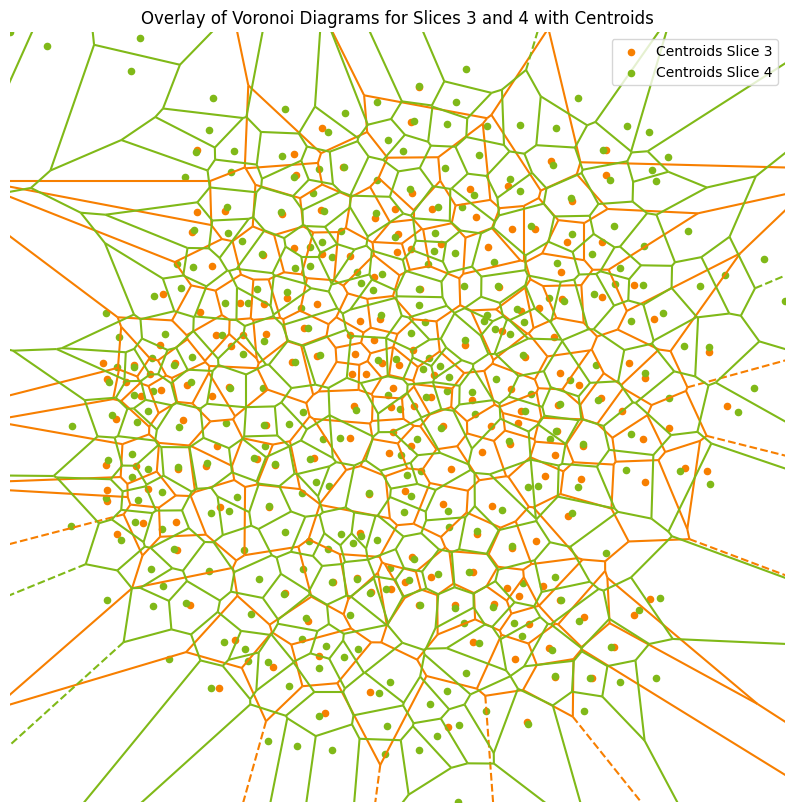

In [7]:

# Convert centroids to integer coordinates for seeding
centroids_slice_3 = df_slice_3[['centroid-0', 'centroid-1']].to_numpy().astype(int)
centroids_slice_4 = df_slice_4[['centroid-0', 'centroid-1']].to_numpy().astype(int)

# Using the centroids as the points for Voronoi, but making sure we're using (x, y) coordinates
points_slice_3 = np.array([(c, r) for r, c in centroids_slice_3])  # Note the coordinate reversal here
points_slice_4 = np.array([(c, r) for r, c in centroids_slice_4])  # Note the coordinate reversal here

# Construct Voronoi diagrams for each set of centroids
vor_slice_3 = Voronoi(centroids_slice_3)
vor_slice_4 = Voronoi(centroids_slice_4)

# Start the plot
fig, ax = plt.subplots(figsize=(10, 10))
# Choose different colors for each Voronoi diagram to avoid confusion
color_slice_3 = '#f77f00'  # a shade of orange
color_slice_4 = '#80b918'  # a shade of green

# Plot Voronoi diagram of slice 3
voronoi_plot_2d(vor_slice_3, ax=ax, show_points=False, show_vertices=False, line_colors=color_slice_3, line_width=1.5)

# Plot Voronoi diagram of slice 4
voronoi_plot_2d(vor_slice_4, ax=ax, show_points=False, show_vertices=False, line_colors=color_slice_4, line_width=1.5)

# Plot centroids for slice 3
ax.scatter(centroids_slice_3[:, 0], centroids_slice_3[:, 1], color=color_slice_3, s=20, label='Centroids Slice 3')

# Plot centroids for slice 4
ax.scatter(centroids_slice_4[:, 0], centroids_slice_4[:, 1], color=color_slice_4, s=20, label='Centroids Slice 4')

# Set limits based on the centroids
all_centroids = np.vstack((centroids_slice_3, centroids_slice_4))
ax.set_xlim(all_centroids[:, 0].min() - 1, all_centroids[:, 0].max() + 1)
ax.set_ylim(all_centroids[:, 1].min() - 1, all_centroids[:, 1].max() + 1)

# Add title and remove axes
ax.set_title('Overlay of Voronoi Diagrams for Slices 3 and 4 with Centroids')
plt.axis('off')

# Add a legend to the plot
ax.legend()

# Display the plot
plt.show()


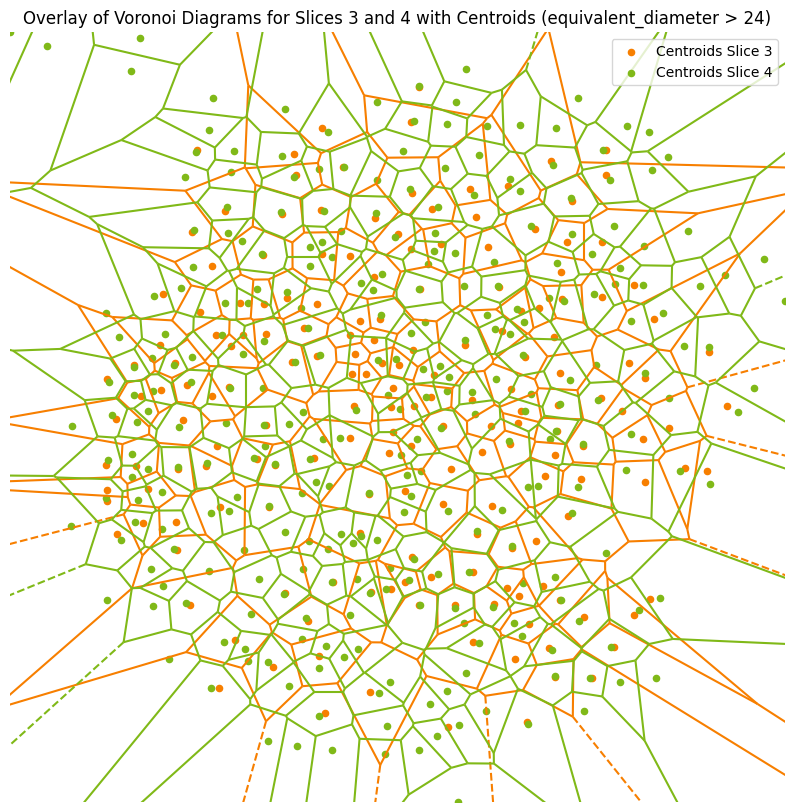

In [13]:
# Diameters to consider
diameter_threshold = 24

# Filter the dataframes to include only rows where 'equivalent_diameter' is greater than 24
filtered_df_slice_3 = df_slice_3[df_slice_3['equivalent_diameter'] > diameter_threshold]
filtered_df_slice_4 = df_slice_4[df_slice_4['equivalent_diameter'] > diameter_threshold]

# Convert centroids to integer coordinates for seeding
centroids_slice_3 = filtered_df_slice_3[['centroid-0', 'centroid-1']].to_numpy().astype(int)
centroids_slice_4 = filtered_df_slice_4[['centroid-0', 'centroid-1']].to_numpy().astype(int)

# Using the centroids as the points for Voronoi, but making sure we're using (x, y) coordinates
points_slice_3 = np.array([(c, r) for r, c in centroids_slice_3])  # Note the coordinate reversal here
points_slice_4 = np.array([(c, r) for r, c in centroids_slice_4])  # Note the coordinate reversal here

# Construct Voronoi diagrams for each set of centroids
vor_slice_3 = Voronoi(centroids_slice_3)
vor_slice_4 = Voronoi(centroids_slice_4)

# Start the plot
fig, ax = plt.subplots(figsize=(10, 10))
# Choose different colors for each Voronoi diagram to avoid confusion
color_slice_3 = '#f77f00'  # a shade of orange
color_slice_4 = '#80b918'  # a shade of green

# Plot Voronoi diagram of slice 3
voronoi_plot_2d(vor_slice_3, ax=ax, show_points=False, show_vertices=False, line_colors=color_slice_3, line_width=1.5)

# Plot Voronoi diagram of slice 4
voronoi_plot_2d(vor_slice_4, ax=ax, show_points=False, show_vertices=False, line_colors=color_slice_4, line_width=1.5)

# Plot centroids for slice 3
ax.scatter(centroids_slice_3[:, 0], centroids_slice_3[:, 1], color=color_slice_3, s=20, label='Centroids Slice 3')

# Plot centroids for slice 4
ax.scatter(centroids_slice_4[:, 0], centroids_slice_4[:, 1], color=color_slice_4, s=20, label='Centroids Slice 4')

# Set limits based on the centroids
all_centroids = np.vstack((centroids_slice_3, centroids_slice_4))
ax.set_xlim(all_centroids[:, 0].min() - 1, all_centroids[:, 0].max() + 1)
ax.set_ylim(all_centroids[:, 1].min() - 1, all_centroids[:, 1].max() + 1)

# Add title and remove axes
ax.set_title(f'Overlay of Voronoi Diagrams for Slices 3 and 4 with Centroids (equivalent_diameter > {diameter_threshold})')
plt.axis('off')

# Add a legend to the plot
ax.legend()

# Display the plot
plt.show()

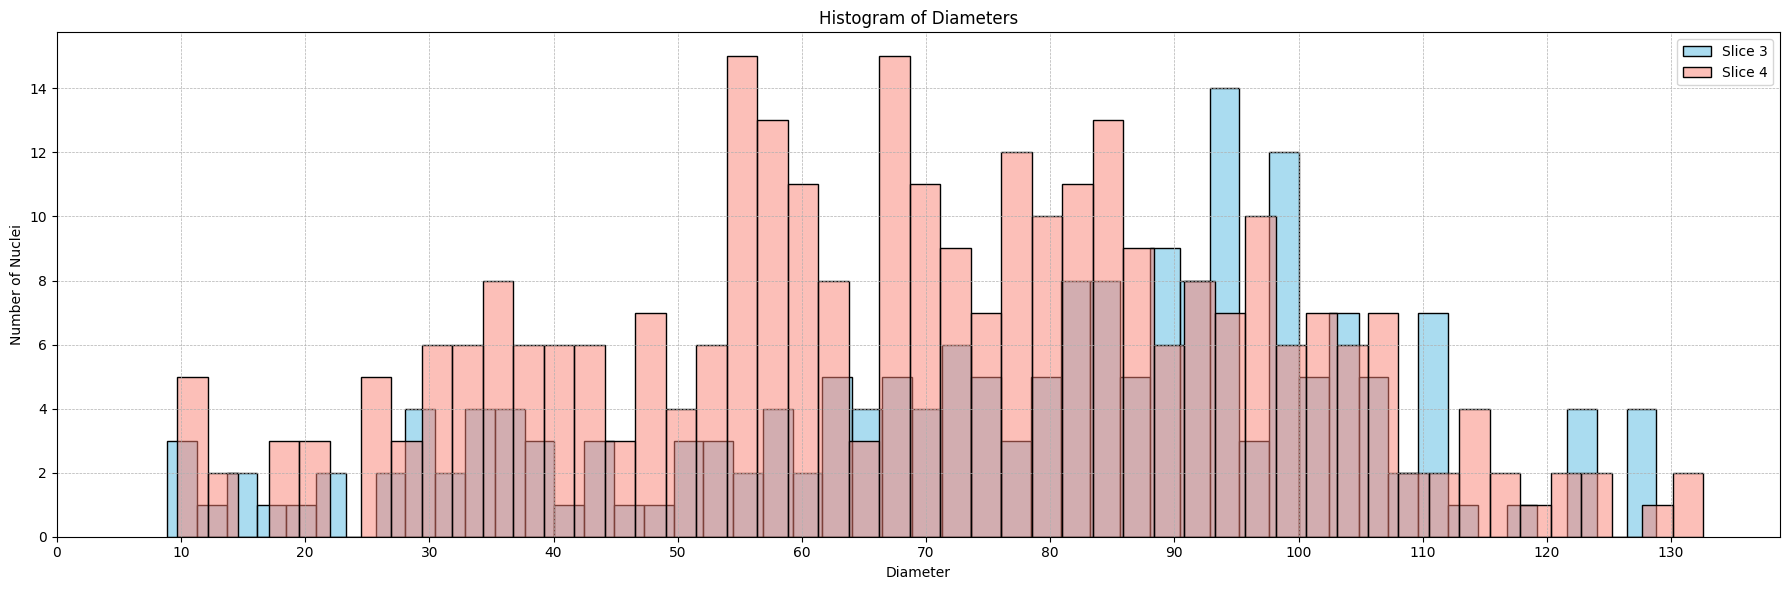

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(18, 6))

# Plot histogram for df_slice_3
sns.histplot(df_slice_3, x='equivalent_diameter', bins=50, color='skyblue', label='Slice 3', element='bars', stat='count', alpha=0.7)

# Plot histogram for df_slice_4
sns.histplot(df_slice_4, x='equivalent_diameter', bins=50, color='salmon', label='Slice 4', element='bars', stat='count', alpha=0.5)

# Plot customization to resemble the original plot
plt.title('Histogram of Diameters')
plt.xlabel('Diameter')
plt.ylabel('Number of Nuclei')

# Set x-ticks starting from 0 and every 10 units
xmax = max(df_slice_3['equivalent_diameter'].max(), df_slice_4['equivalent_diameter'].max())  # Get the maximum value from both datasets
plt.xticks(np.arange(0, xmax + 1, 10))

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()  # Display the legend
plt.tight_layout()
plt.show()
